<a href="https://colab.research.google.com/github/AjayK456/AI-MRI-Denoiser/blob/main/MRI_Denoising_AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install PyTorch (Colab usually has it pre-installed)
!pip install torch torchvision torchaudio --quiet
# Additional useful packages
!pip install matplotlib scikit-image opencv-python pydicom --quiet
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import os
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim


   ━━━━━━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━ 228.5/363.4 MB 84.9 MB/s eta 0:00:02
ERROR: Operation cancelled by user
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 6.5 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')



MessageError: Error: credential propagation was unsuccessful

In [ ]:
# Example path for saving models
model_path = "/content/drive/MyDrive/MRI_Denoising/models/"
os.makedirs(model_path, exist_ok=True)


In [ ]:
!mkdir -p /content/MRI_Denoising/data/train/noisy
!mkdir -p /content/MRI_Denoising/data/train/clean
!mkdir -p /content/MRI_Denoising/models
!mkdir -p /content/MRI_Denoising/outputs


In [ ]:
import tarfile

# Path to your uploaded tar.gz file on Google Drive
tar_path = "/content/drive/MyDrive/MRI_Denoising/raw/IXI-dataset.tar.gz"
extract_path = "/content/IXI_dataset/"

# Extract the dataset


with tarfile.open(tar_path, "r:gz") as tar:
    tar.extractall(path=extract_path)

print("✅ Extraction complete.")

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/MRI_Denoising/raw/IXI-dataset.tar.gz'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import os

base_path = "/content/drive/MyDrive"
for root, dirs, files in os.walk(base_path):
    for name in files:
        if name.endswith(".tar.gz"):
            print(os.path.join(root, name))


/content/drive/MyDrive/MRI_Denoising/raw/IXI-dataset.tar.gz


In [ ]:
tar_path = "/content/drive/MyDrive/MRI_Denoising/raw/IXI-dataset.tar.gz"
extract_path = "/content/IXI_dataset/"

import tarfile
with tarfile.open(tar_path, "r:gz") as tar:
    tar.extractall(path=extract_path)

print("✅ Extraction complete.")


✅ Extraction complete.


In [ ]:
import nibabel as nib
import cv2
import numpy as np
from tqdm import tqdm

clean_output_dir = "/content/MRI_Denoising/data/train/clean/"
os.makedirs(clean_output_dir, exist_ok=True)

def extract_middle_slices(nii_file, out_folder, max_slices=10):
    img = nib.load(nii_file)
    volume = img.get_fdata()

    # Normalize volume to 0–255
    volume = np.nan_to_num(volume)  # remove NaNs
    volume = (volume - volume.min()) / (volume.max() - volume.min()) * 255
    volume = volume.astype(np.uint8)

    # Select middle slices
    depth = volume.shape[2]
    start = depth // 2 - max_slices // 2
    end = start + max_slices

    for i in range(start, end):
        slice_img = volume[:, :, i]
        filename = f"{os.path.basename(nii_file)[:-4]}_slice{i}.png"
        save_path = os.path.join(out_folder, filename)
        cv2.imwrite(save_path, slice_img)

# Process all .nii files
nii_files = []
for root, _, files in os.walk(extract_path):
    for f in files:
        if f.endswith(".nii") or f.endswith(".nii.gz"):
            nii_files.append(os.path.join(root, f))

print(f"Found {len(nii_files)} .nii files")

# Extract 10 slices from each
for f in tqdm(nii_files[:5]):  # You can increase from 5 to more if needed
    extract_middle_slices(f, clean_output_dir)


Found 0 .nii files


0it [00:00, ?it/s]


In [ ]:
import tarfile

with tarfile.open(tar_path, "r:gz") as tar:
    tar.list()


?rwxr-xr-x mdiazmel/SED-pro          0 2020-12-17 22:22:30 IXI-dataset/ 
?rwxr-xr-x mdiazmel/SED-pro          0 2020-12-01 18:28:16 IXI-dataset/size64/ 
?rwxr-xr-x mdiazmel/SED-pro      33113 2020-12-01 18:28:16 IXI-dataset/size64/sub-IXI368 - T1.pt 
?rwxr-xr-x mdiazmel/SED-pro      33113 2020-12-01 18:28:16 IXI-dataset/size64/sub-IXI423 - T1.pt 
?rwxr-xr-x mdiazmel/SED-pro      33113 2020-12-01 18:28:16 IXI-dataset/size64/sub-IXI036 - T2.pt 
?rwxr-xr-x mdiazmel/SED-pro      33113 2020-12-01 18:28:16 IXI-dataset/size64/sub-IXI022 - T2.pt 
?rwxr-xr-x mdiazmel/SED-pro      33113 2020-12-01 18:28:16 IXI-dataset/size64/sub-IXI136 - T1.pt 
?rwxr-xr-x mdiazmel/SED-pro      33113 2020-12-01 18:28:16 IXI-dataset/size64/sub-IXI555 - T1.pt 
?rwxr-xr-x mdiazmel/SED-pro      33113 2020-12-01 18:28:16 IXI-dataset/size64/sub-IXI123 - T2.pt 
?rwxr-xr-x mdiazmel/SED-pro      33113 2020-12-01 18:28:16 IXI-dataset/size64/sub-IXI118 - T2.pt 
?rwxr-xr-x mdiazmel/SED-pro      33113 2020-12-01 18:28:16 IXI-

In [ ]:
import torch
import os

pt_path = "/content/IXI_dataset/IXI-dataset/size64/"

for file in os.listdir(pt_path):
    if file.endswith(".pt"):
        tensor = torch.load(os.path.join(pt_path, file))
        print(f"{file}: shape = {tensor.shape}")
        break  # just preview one for now


sub-IXI185 - T1.pt: shape = torch.Size([64, 64])


In [ ]:
from torch.utils.data import Dataset
import torch
import os
import random

class MRIDenoisingDataset(Dataset):
    def __init__(self, data_dir, noise_std=0.1, transform=None):
        self.data_dir = data_dir
        self.files = [f for f in os.listdir(data_dir) if f.endswith('.pt')]
        self.noise_std = noise_std
        self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        file_path = os.path.join(self.data_dir, self.files[idx])
        clean_img = torch.load(file_path).float() / 255.0  # Normalize to [0,1]

        if self.transform:
            clean_img = self.transform(clean_img)

        # Add Gaussian noise
        noise = torch.randn_like(clean_img) * self.noise_std
        noisy_img = clean_img + noise
        noisy_img = torch.clamp(noisy_img, 0., 1.)

        return noisy_img.unsqueeze(0), clean_img.unsqueeze(0)
dataset = MRIDenoisingDataset("/content/IXI_dataset/IXI-dataset/size64", noise_std=0.1)

noisy, clean = dataset[0]
print("Noisy image shape:", noisy.shape)
print("Clean image shape:", clean.shape)


Noisy image shape: torch.Size([1, 64, 64])
Clean image shape: torch.Size([1, 64, 64])


In [ ]:
from torch.utils.data import DataLoader

# Split dataset (optional: you can split further for val/test later)
train_loader = DataLoader(
    dataset,
    batch_size=16,
    shuffle=True,
    num_workers=2,  # adjust depending on your system
    pin_memory=True
)


In [ ]:
import torch.nn as nn

class DenoisingCNN(nn.Module):
    def __init__(self):
        super(DenoisingCNN, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1), nn.ReLU(),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 2, stride=2), nn.ReLU(),
            nn.Conv2d(32, 1, 3, padding=1), nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [ ]:
model = DenoisingCNN().to("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


In [ ]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

num_epochs = 10
model.train()

for epoch in range(num_epochs):
    total_loss = 0.0
    for noisy_imgs, clean_imgs in train_loader:
        noisy_imgs = noisy_imgs.to(device)
        clean_imgs = clean_imgs.to(device)

        outputs = model(noisy_imgs)
        loss = criterion(outputs, clean_imgs)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")


Epoch [1/10], Loss: 0.0423
Epoch [2/10], Loss: 0.0000
Epoch [3/10], Loss: 0.0000
Epoch [4/10], Loss: 0.0000
Epoch [5/10], Loss: 0.0000
Epoch [6/10], Loss: 0.0000
Epoch [7/10], Loss: 0.0000
Epoch [8/10], Loss: 0.0000
Epoch [9/10], Loss: 0.0000
Epoch [10/10], Loss: 0.0000


In [ ]:
torch.save(model.state_dict(), "/content/drive/MyDrive/MRI_Denoising/models/denoising_cnn.pth")


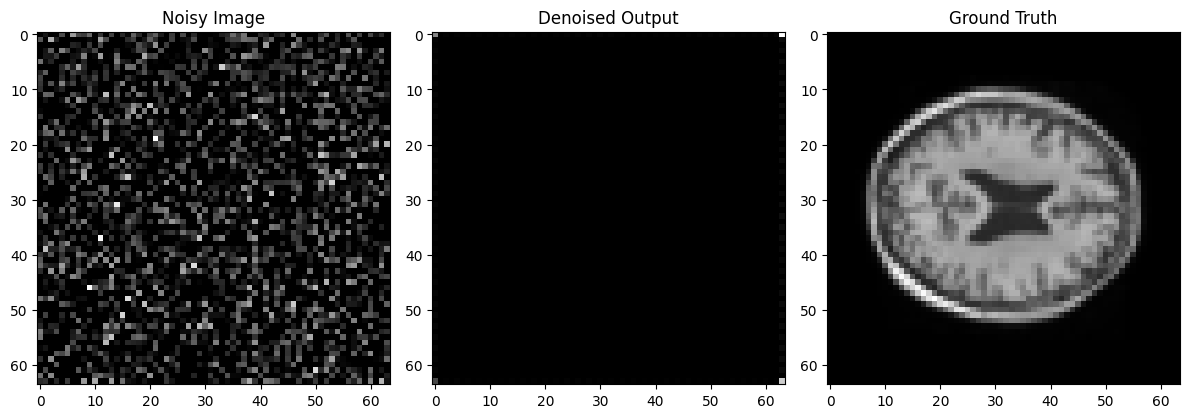

In [ ]:
import matplotlib.pyplot as plt

model.eval()
with torch.no_grad():
    noisy_img, clean_img = dataset[0]
    noisy_img = noisy_img.unsqueeze(0).to(device)
    denoised_img = model(noisy_img).cpu().squeeze().numpy()

# Convert others to numpy for plotting
noisy_np = noisy_img.cpu().squeeze().numpy()
clean_np = clean_img.squeeze().numpy()

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.title("Noisy Image")
plt.imshow(noisy_np, cmap="gray")

plt.subplot(1, 3, 2)
plt.title("Denoised Output")
plt.imshow(denoised_img, cmap="gray")

plt.subplot(1, 3, 3)
plt.title("Ground Truth")
plt.imshow(clean_np, cmap="gray")

plt.tight_layout()
plt.show()


In [ ]:
from sklearn.model_selection import train_test_split

# Assume this contains full paths to your .pt files
all_files = [os.path.join(pt_path, f) for f in os.listdir(pt_path) if f.endswith('.pt')]

train_files, testval_files = train_test_split(all_files, test_size=0.3, random_state=42)
val_files, test_files = train_test_split(testval_files, test_size=0.5, random_state=42)

print(f"Train: {len(train_files)} | Val: {len(val_files)} | Test: {len(test_files)}")


Train: 807 | Val: 173 | Test: 174


In [ ]:
class MRIDenoisingDataset(Dataset):
    def __init__(self, file_list):
        self.files = file_list

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        clean_img = torch.load(self.files[idx])
        noisy_img = clean_img + torch.randn_like(clean_img) * 0.1
        return noisy_img.unsqueeze(0), clean_img.unsqueeze(0)


In [ ]:

# Create dataset instances
train_dataset = MRIDenoisingDataset(train_files)
val_dataset = MRIDenoisingDataset(val_files)
test_dataset = MRIDenoisingDataset(test_files)

# Create DataLoaders
from torch.utils.data import DataLoader

batch_size = 32  # You can adjust this based on your GPU

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class DenoisingAutoencoder(nn.Module):
    def __init__(self):
        super(DenoisingAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1), nn.ReLU(),
            nn.Conv2d(16, 8, 3, padding=1), nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Conv2d(8, 16, 3, padding=1), nn.ReLU(),
            nn.Conv2d(16, 1, 3, padding=1)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

model = DenoisingAutoencoder().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


In [ ]:
def evaluate_model(model, loader, criterion):
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for noisy, clean in loader:
            noisy, clean = noisy.to(device), clean.to(device)
            output = model(noisy)
            loss = criterion(output, clean)
            val_loss += loss.item() * noisy.size(0)
    return val_loss / len(loader.dataset)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define a simple CNN model (example if not defined yet)
class DenoisingCNN(nn.Module):
    def __init__(self):
        super(DenoisingCNN, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 8, 3, padding=1),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Conv2d(8, 16, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 1, 3, padding=1),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Instantiate model, loss, optimizer
model = DenoisingCNN().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Prepare DataLoaders
train_dataset = MRIDenoisingDataset(train_files)
val_dataset = MRIDenoisingDataset(val_files)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

# Evaluation function
def evaluate_model(model, loader, criterion):
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for noisy, clean in loader:
            noisy, clean = noisy.float().to(device), clean.float().to(device)
            output = model(noisy)
            loss = criterion(output, clean)
            val_loss += loss.item() * noisy.size(0)
    return val_loss / len(loader.dataset)

# Training loop
epochs = 5  # You can increase this if training works fine

for epoch in range(epochs):
    model.train()
    train_loss = 0.0

    for noisy, clean in train_loader:
        noisy, clean = noisy.float().to(device), clean.float().to(device)
        optimizer.zero_grad()
        output = model(noisy)
        loss = criterion(output, clean)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * noisy.size(0)

    train_loss /= len(train_loader.dataset)
    val_loss = evaluate_model(model, val_loader, criterion)
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")


Epoch 1/5, Train Loss: 0.0707, Val Loss: 0.0164
Epoch 2/5, Train Loss: 0.0090, Val Loss: 0.0057
Epoch 3/5, Train Loss: 0.0050, Val Loss: 0.0045
Epoch 4/5, Train Loss: 0.0043, Val Loss: 0.0042
Epoch 5/5, Train Loss: 0.0040, Val Loss: 0.0039


In [ ]:
model_save_path = "/content/drive/MyDrive/MRI_Denoising/models/denoising_autoencoder.pth"
torch.save(model.state_dict(), model_save_path)


Test Loss on Unseen Data: 0.0039


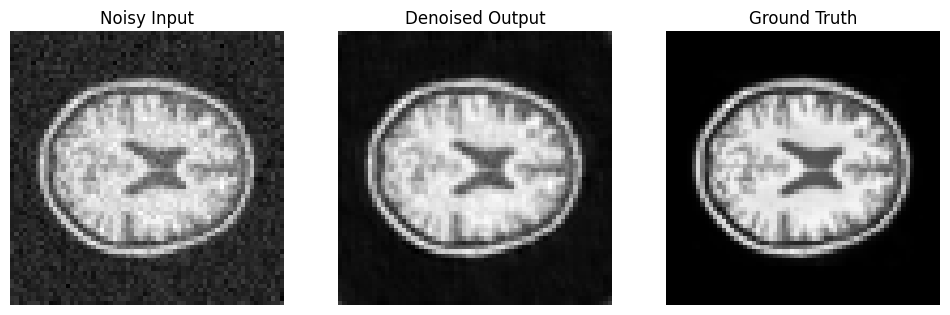

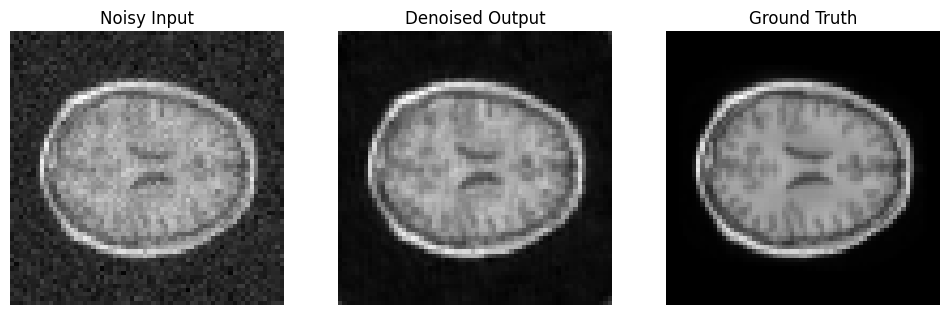

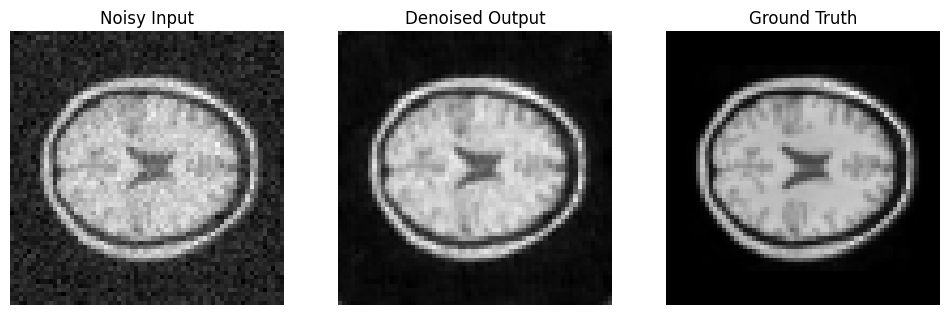

In [ ]:
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

# --- Reuse your test split and dataset class ---
test_dataset = MRIDenoisingDataset(test_files)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# --- Define evaluation function ---
def test_model(model, loader, criterion):
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for noisy, clean in loader:
            noisy, clean = noisy.to(device).float(), clean.to(device).float()
            output = model(noisy)
            loss = criterion(output, clean)
            test_loss += loss.item() * noisy.size(0)
    return test_loss / len(loader.dataset)

# --- Define visualization function ---
def show_denoising_results(model, loader, num_samples=3):
    model.eval()
    samples_shown = 0
    with torch.no_grad():
        for noisy, clean in loader:
            noisy, clean = noisy.to(device).float(), clean.to(device).float()
            output = model(noisy)

            noisy_np = noisy.cpu().squeeze().numpy()
            output_np = output.cpu().squeeze().numpy()
            clean_np = clean.cpu().squeeze().numpy()

            plt.figure(figsize=(12, 4))
            plt.subplot(1, 3, 1)
            plt.title("Noisy Input")
            plt.imshow(noisy_np, cmap="gray")
            plt.axis("off")

            plt.subplot(1, 3, 2)
            plt.title("Denoised Output")
            plt.imshow(output_np, cmap="gray")
            plt.axis("off")

            plt.subplot(1, 3, 3)
            plt.title("Ground Truth")
            plt.imshow(clean_np, cmap="gray")
            plt.axis("off")

            plt.show()

            samples_shown += 1
            if samples_shown >= num_samples:
                break

# --- Run test and visualization ---
criterion = nn.MSELoss()
test_loss = test_model(model, test_loader, criterion)
print(f"Test Loss on Unseen Data: {test_loss:.4f}")

show_denoising_results(model, test_loader, num_samples=3)


In [ ]:
torch.save(model, "denoising_full_model.pth")


In [ ]:
def denoise_image(file_path):
    model.eval()
    img = torch.load(file_path).float().unsqueeze(0).unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(img)
    return output.squeeze().cpu()
